In [1]:
from ipywidgets import interactive
import ipywidgets as widgets

import os
import copy
from pathlib import Path
import h5py as h5
from ipywidgets import interactive
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#%matplotlib widget

import itertools


import numpy as np
import matplotlib
from scipy.optimize import curve_fit
from pydidas.core import Dataset, UserConfigError
from pydidas.data_io import import_data

%matplotlib inline

import sys

from dataclasses import dataclass
from scipy.optimize import curve_fit

from pydidas.core.constants import PROC_PLUGIN, PROC_PLUGIN_INTEGRATED
from pydidas.plugins import ProcPlugin


#We need to append the path to the sys.path to import the module
sys.path.append('../src/pydidas_plugins/proc_plugins')

from sin2chi_grouping import S2C_TOLERANCE, DspacingSin2chiGrouping
from sin_2chi import DspacingSin_2chi 

  plt.tight_layout()



Shape of dataset
 (18, 21, 36, 5)
Dimension of dataset after slicing
 2
🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝
['_config', '_generics', '_roi_data_dim', 'advanced_parameters', 'base_classes', 'basic_plugin', 'config', 'default_params', 'generic_params', 'has_unique_parameter_config_widget', 'input_data', 'input_data_dim', 'input_shape', 'new_dataset', 'node_id', 'output_data_dim', 'output_data_label', 'output_data_unit', 'param_keys', 'param_values', 'params', 'plugin_name', 'plugin_subtype', 'plugin_type', 'q_settings', 'q_settings_version', 'result_data_label', 'result_title', 'staticMetaObject', 'test_mode']
{'test_mode': False, 'input_data': None, '_chi_key': None, '_pos_key': None, '_pos_idx': None, '_s2c_labels': None, '_n_components': None}
🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝🐝
The dataset:
 Dataset(
axis_labels: {
    0: 'chi'},
axis_ranges: {
    0: array([-175.      , -164.999999, -154.999999, ...,  155.00002 ,
               165.000021,  175.000021])},
axis_units: {
    0: 'deg'},
metadata

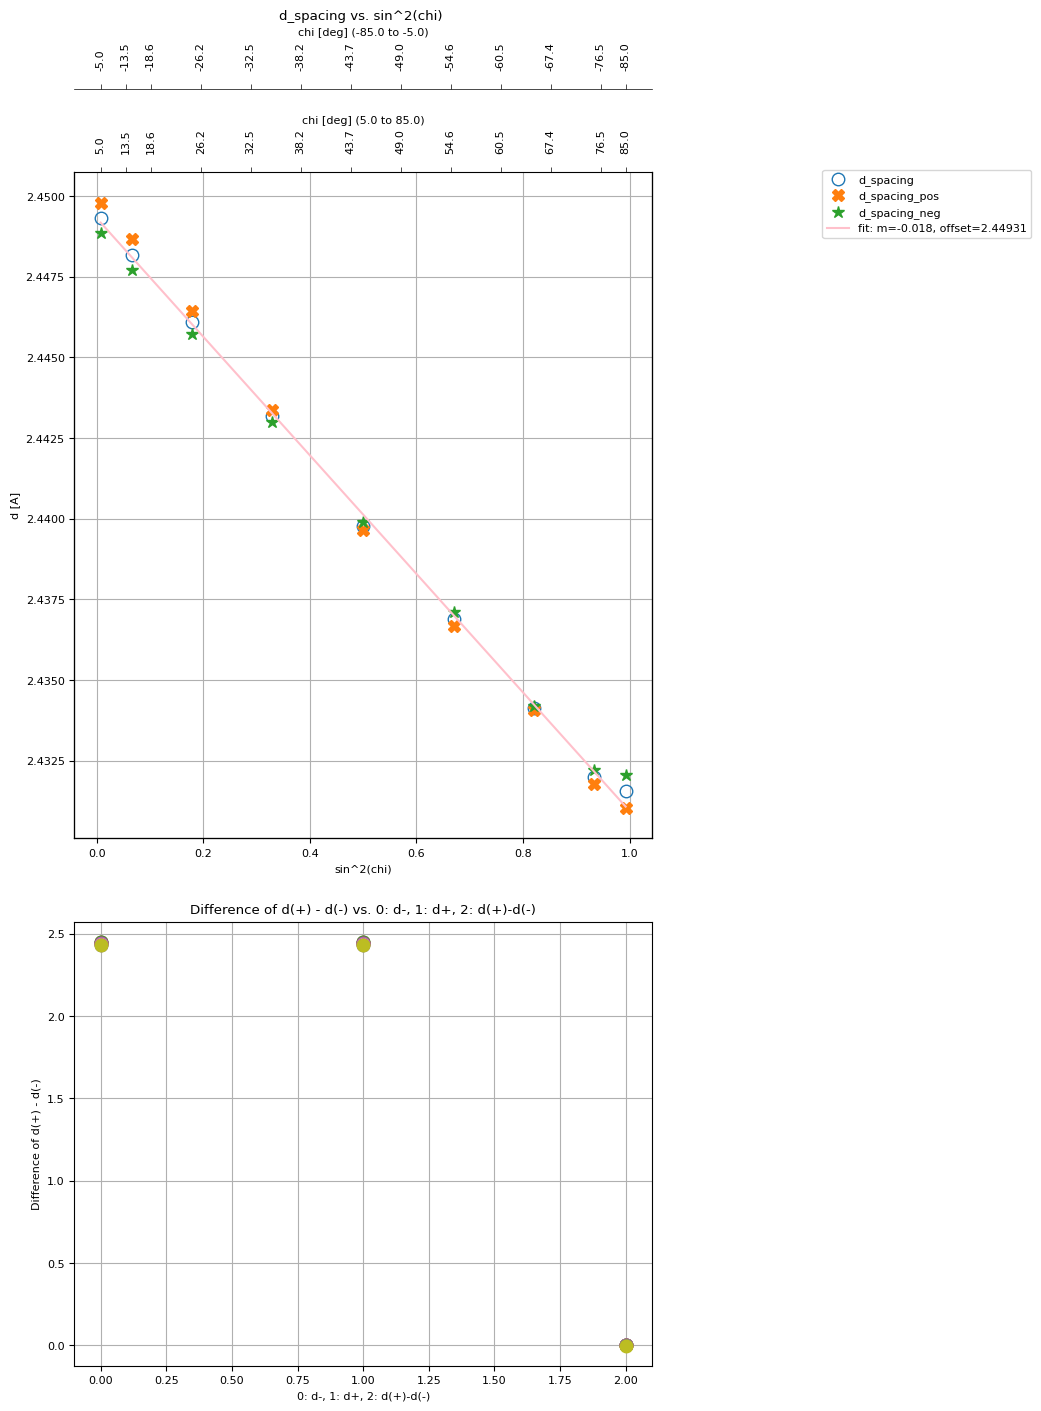

ds_diff shape (3, 9)
Dataset(
axis_labels: {
    0: '0: d-, 1: d+, 2: d(+)-d(-)'
    1: 'sin(2*chi)'},
axis_ranges: {
    0: array([0, 1, 2])
    1: array([0.173648, 0.5     , 0.766044, 0.939693, 1.      , 0.939693,
              0.766044, 0.5     , 0.173648])},
axis_units: {
    0: ''
    1: ''},
metadata: {},
data_unit: A,
data_label: Difference of d(+) - d(-),
array([[ 2.448858e+00,  2.447691e+00, ...,  2.432222e+00,  2.432066e+00],
       [ 2.449796e+00,  2.448655e+00, ...,  2.431778e+00,  2.431032e+00],
       [ 9.374619e-04,  9.635687e-04, ..., -4.440546e-04, -1.034021e-03]])
)


In [2]:

@dataclass
class Real_Dataset_Info:
    path: Path
    fname: str
    
    def fpath(self) -> Path:
        return self.path / Path(self.fname)
    
def chi_gen(chi_start, chi_stop, delta_chi):
    if chi_start >= chi_stop:
        raise ValueError('chi_start has to be smaller than chi_stop')
    if delta_chi <= 0:
        raise ValueError('delta_chi has to be greater than 0')
    return np.arange(chi_start, chi_stop, delta_chi)


def predefined_metric_calculation(metric_name, chi, x, y, d0, spatial_var, phase_shift):
    """ Calculate predefined metric based on name, applying spatial variation even if x is not provided. """
    # Handle spatial variation by introducing a default or random x if none is provided
    if x is None and spatial_var:
        x = np.random.uniform(0, 1)  #A random x between 0 and 5
    if metric_name == "position":
        return 0.2832*np.sin(np.deg2rad(chi+phase_shift))**2 + d0 + (0.01 * x if spatial_var else 0)
    if metric_name == "area":
        return np.random.uniform(6, 37, size=len(chi)) + 0.1 * y
    if metric_name == "FWHM":
        return np.random.uniform(0.35, 0.75, size=len(chi))
    if metric_name == "background at peak":
        return np.random.uniform(2.3, 5.3, size=len(chi))
    if metric_name == "total count intensity":
        return np.random.uniform(80, 800, size=len(chi))
    return np.random.uniform(1.5708, 3.141, size=len(chi))  # Fallback for unknown metrics

def plot_sin2chi(chi):
    fig, ax = plt.subplots()
    ax.plot(chi, np.sin(np.deg2rad(chi))**2, linestyle='None', marker='o')
    ax.set_xlabel('chi [deg]')
    ax.set_ylabel('sin^2(chi)')
    ax.set_title('sin^2(chi) vs chi')
    ax.grid()
    plt.show()

def generate_spatial_fit_res(y_range, x_range=None, chi_start=-175, chi_stop=180, delta_chi=10, fit_labels=None, spatial_var=True, phase_shift=0):
    '''
    chi [degree]
    phase_shift [degree]
    '''
    
    if fit_labels is None:
        fit_labels = '0: position; 1: area; 2: FWHM; 3: background at peak; 4: total count intensity'
    fit_labels_dict = {int(k.split(':')[0].strip()): k.split(':')[1].strip() for k in fit_labels.replace(', ', ';').split(';')}

    chi = chi_gen(chi_start, chi_stop, delta_chi)
    d0 = 25  # in nm

    # Determine the dimensions based on x_range
    if x_range is not None:
        result_array = np.empty((len(y_range), len(x_range), len(chi), len(fit_labels_dict)))
    else:
        result_array = np.empty((len(y_range), len(chi), len(fit_labels_dict)))
        x_range = [None]  # Simulate the absence of x values

    # Perform calculations for each y and x, and across all metrics
    for j, y in enumerate(y_range):
        for i, x in enumerate(x_range):
            fit_results = []
            for idx in sorted(fit_labels_dict.keys()):
                metric_name = fit_labels_dict[idx]
                result = predefined_metric_calculation(metric_name, chi, x, y, d0, spatial_var, phase_shift)
                fit_results.append(result)

            fit_results = np.array(fit_results)
            # Adjust how results are stored based on the presence of x_range
            # Debug print statements
            #print(f"fit_results.T.shape: {fit_results.T.shape}, j: {j}, i: {i}")
            #print('x_range:', x_range)
            if x is not None:
                result_array[j, i, :, :] = fit_results.T
            else:
                result_array[j, :, :] = fit_results.T  # Ensure dimensionality matches expected (len(chi), len(fit_labels_dict))

    return result_array

def adding_noise_d_spacing(d_spacing, scale=0.03, mean_value=1, seed=10):
    '''
    ds: Dataset, expecting in first column d-spacing values.
    Noise follows a Laplace distribution
    mean_value, scale: Mean_value and scale parameter of Laplace distribution
    Seed: radnom seed
    
    '''
    ds = d_spacing.copy()
    #Introducing seed and random noise for d_spacing
    # Define the scale parameter for the Laplace distribution
    # Generate Laplace noise centered around the mean value
    d_spacing_noise = np.random.default_rng(seed=seed).laplace(mean_value, scale, size=d_spacing.array.shape[0])
 
    d_spacing_with_noise = d_spacing.array[:,0] + d_spacing_noise
    print(30*"\N{peach}")
    print(ds.array)
    print(30*"\N{peach}")
    print(d_spacing_noise)
    print(30*"\N{peach}")
    
    #update array in ds
    ds.array[:,0] = d_spacing_with_noise
    return ds
  


def plot_d_spacing_vs_chi_1d(ds, chi, scan_axis):
    
    print('ds.shape:', ds.shape)
    
    chi_key, (pos_key, pos_idx)  = chi_pos_verification(ds)
    
    fig, ax = plt.subplots()
    
    for pos in ds.axis_ranges[scan_axis]:
        # Extract d_spacing for the specific position
        d_spacing = ds[pos, :, ]
   

def plot_d_spacing_vs_chi_2d(ds, chi, positions):
    """
    Plots d_spacing vs chi for specified (x, y) positions in the result array using Matplotlib's OOP interface.

    Parameters:
        ds (Dataset): The 4D array containing measurement data.
        chi (numpy.ndarray): The array of chi values.
        positions (list of tuples): A list of (x_index, y_index) tuples specifying the positions to plot.
    """    
    fig, ax = plt.subplots(figsize=(10, 6))
    for (x_index, y_index) in positions:
        # Extract d_spacing for the specific position
        d_spacing = ds.array[x_index, y_index, :, 0]  # d_spacing is the first property in the last dimension
        
        # Plotting using the axes object
        ax.plot(chi, d_spacing, label=f'(x={x_index}, y={y_index})', marker='o', linestyle='--')
    
    ax.set_xlabel('chi [deg]')
    ax.set_ylabel('d_spacing')
    ax.set_title('d_spacing vs. chi for various x,y')
    ax.grid(True)
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
   
def split_fit_labels(input_string):

    # Split the string into key:value pairs
    pairs = input_string.split(';')

    # Initialize an empty dictionary to hold the key:value pairs
    result_dict = {}

    # Loop through each pair, split it into key and value, and add them to the dictionary
    for pair in pairs:
        # Strip any extra whitespace
        pair = pair.strip()
        # Split the pair into key and value
        if pair:
            key, value = pair.split(': ')
            # Add the key:value to the dictionary
            result_dict[int(key)] = value


    return result_dict


def plot_d_spacing_vs_chi_by_grouping(d_spacing, chi, s2c_labels, n_components):
    
    """ Plot d_spacing vs chi, coloring indicating grouping based on sin^2(chi) values and slope """

    
   # Prepare the color map and normalization for coloring by group
    cmap = plt.get_cmap('viridis_r')
    norm = matplotlib.colors.Normalize(vmin=min(s2c_labels), vmax=max(s2c_labels))
    colors = cmap(norm(s2c_labels))  # Map s2c_labels to colors
        
    # Define a list of markers for different groups
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'H', 'd', '8', 'P', 'X', 'x', '+', '|']
    
    # If there are more groups than markers, repeat the markers cyclically
    if n_components > len(markers):
        print(f"Warning: More groups ({n_components}) than unique markers ({len(markers)}). Markers will repeat.")
        markers = (markers * ((n_components // len(markers)) + 1))[:n_components]
    
    # Create subplots
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot chi vs d_spacing with colors and markers
    for i in range(n_components):
        indices = np.where(s2c_labels == i)
        ax.scatter(chi[indices], d_spacing[indices], c=[colors[idx] for idx in indices[0]], 
                   marker=markers[i], edgecolor='k', label=f'Group {i}', zorder=2)
    
    # Set labels and title
    ax.set_ylabel(f'{d_spacing.data_label} [{d_spacing.data_unit}]')
    ax.set_xlabel(f'{d_spacing.axis_labels[0]} [{d_spacing.axis_units[0]}]')
    ax.set_title(f'{d_spacing.data_label} vs. {d_spacing.axis_labels[0]}')
    ax.grid()
    
    # Create a legend with unique markers and colors
    handles = [plt.Line2D([0], [0], marker=markers[i], color='k', markerfacecolor=cmap(norm(i)), 
                          markersize=10, linestyle='None', label=f'Group {i}') for i in range(n_components)]
    legend_columns = 2 if n_components > 17 else 1
    ax.legend(handles=handles, title='Groups', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=legend_columns)
    
    # Calculate sin^2(chi)
    sin2chi = np.sin(np.deg2rad(chi)) ** 2

    # Create a second x-axis for sin^2(chi)
    secax = ax.secondary_xaxis('top')
    secax.set_xlabel(r'$\sin^2(\chi)$')

    # Match secondary axis ticks with primary axis ticks
    primary_ticks = ax.get_xticks()  # Get the current tick positions on the primary x-axis
    sin2chi_ticks = np.sin(np.deg2rad(primary_ticks)) ** 2  # Calculate sin^2(chi) for these ticks
    
    secax.set_xticks(primary_ticks)  # Set the same tick positions on the secondary axis
    secax.set_xticklabels([f'{tick:.3f}' for tick in sin2chi_ticks], rotation=90)

    plt.tight_layout()
    plt.show()



    
def add_horizontal_intervals(ax, sin2chi, tolerance, linewidth=0.5):
    """
    Add horizontal lines to the given axis at intervals around each value in sin2chi.
    
    Parameters:
        ax (matplotlib.axes.Axes): The axis to which horizontal lines will be added.
        sin2chi (np.ndarray): Array of sin^2(chi) values.
        tolerance (float): Tolerance value to define the intervals around each sin2chi value.
        color (str): Color of the horizontal lines.
        linestyle (str): Style of the horizontal lines.
        linewidth (float): Width of the horizontal lines.
    """
    # Calculate min and max of sin2chi
    y_min_sin2chi = np.min(sin2chi)
    y_max_sin2chi = np.max(sin2chi)
    
    # Get current y-axis limits of the plot
    y_min_plot, y_max_plot = ax.get_ylim()
    
    # Define intervals around each value in sin2chi
    intervals = []
    for value in sin2chi:
        lower_bound = value - tolerance / 2
        upper_bound = value + tolerance / 2
        intervals.append((lower_bound, upper_bound))
    
    # Remove duplicate intervals and sort
    unique_intervals = sorted(set(intervals))
    
    # Draw lines within the visible y-axis range
    for lower, upper in unique_intervals:
        # Ensure lines are within the range of the plot's y-axis limits
        if lower <= y_max_plot and upper >= y_min_plot:
            # Clip the bounds to the visible y-axis range
            clipped_lower = max(lower, y_min_plot)
            clipped_upper = min(upper, y_max_plot)
            ax.axhline(y=clipped_lower, color='pink', linestyle='dotted', linewidth=linewidth, zorder=1)
            if clipped_upper != clipped_lower:
                ax.axhline(y=clipped_upper, color='red', linestyle='dashdot', linewidth=linewidth, zorder=1)




def plot_combined(d_spacing, chi, s2c_labels, n_components):
    """ 
    Plot d_spacing vs chi, sin^2(chi) vs chi, and sin^2(chi) vs d_spacing with coloring and markers indicating grouping 
    """
    print('s2c_labels\n', s2c_labels)
    print('len(s2c_labels):', len(s2c_labels))  
    print('unique(s2c_labels):\n', np.unique(s2c_labels))
    print('len(unique(s2c_labels)): ',len(np.unique(s2c_labels)),'\n')
    
    print('length of chi:', len(chi))
    
      
    # Calculate sin^2(chi)
    sin2chi = np.sin(np.deg2rad(chi)) ** 2
    print('n_components:', n_components)
    print('chi\n', chi)
      
    
    print('sin2chi', sin2chi[np.unique(s2c_labels)])
          
    # Prepare the color map and normalization for coloring by group
    cmap = plt.get_cmap('viridis_r')
    norm = matplotlib.colors.Normalize(vmin=min(s2c_labels), vmax=max(s2c_labels))
    colors = cmap(norm(s2c_labels))  # Map s2c_labels to colors
    
    # Define a list of markers for different groups
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'H', 'd', '8', 'P', 'X', 'x', '+', '|']
    
    # If there are more groups than markers, repeat the markers cyclically
    if n_components > len(markers):
        print(f"Warning: More groups ({n_components}) than unique markers ({len(markers)}). Markers will repeat.")
        markers = (markers * ((n_components // len(markers)) + 1))[:n_components]
        

    # Create subplots: 2 in the first row, 1 spanning the second row
    fig = plt.figure(figsize=(15.5, 10))
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    ax3 = plt.subplot2grid((2, 2), (1,0))
    ax4 = plt.subplot2grid((2, 2), (1, 1))
    
    # Plot d_spacing vs chi
    for i in range(n_components):
        indices = np.where(s2c_labels == i)
        ax1.scatter(chi[indices], d_spacing[indices], c=colors[indices], marker=markers[i], edgecolor='k', label=f'{i}')
    
    # Set labels and title for the first plot
    ax1.set_ylabel(f'{d_spacing.data_label} [{d_spacing.data_unit}]')
    ax1.set_xlabel(f'{d_spacing.axis_labels[0]} [{d_spacing.axis_units[0]}]')
    ax1.set_title(f'{d_spacing.data_label} vs. {d_spacing.axis_labels[0]}')
    ax1.grid()


    # Determine the number of columns for the legend based on the number of groups
    legend_columns = 2 if n_components > 17 else 1
    ax1.legend(title='Groups', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=legend_columns)
    
    # Create a second x-axis for sin^2(chi) on the first plot
    secax = ax1.secondary_xaxis('top')
    secax.set_xlabel(r'$\sin^2(\chi)$')

    # Match secondary axis ticks with primary axis ticks
    primary_ticks = ax1.get_xticks()  # Get the current tick positions on the primary x-axis
    sin2chi_ticks = np.sin(np.deg2rad(primary_ticks)) ** 2  # Calculate sin^2(chi) for these ticks
    
    secax.set_xticks(primary_ticks)  # Set the same tick positions on the secondary axis
    secax.set_xticklabels([f'{tick:.2f}' for tick in sin2chi_ticks], rotation=90)

    # Plot sin^2(chi) vs chi
    for i in range(n_components):
        indices = np.where(s2c_labels == i)
        ax2.scatter(chi[indices], sin2chi[indices], c=colors[indices], marker=markers[i], edgecolor='k', label=f'{i}', zorder=2)
    
    add_horizontal_intervals(ax2, sin2chi, tolerance=S2C_TOLERANCE)
    
    # Set labels and title for the second plot
    ax2.set_xlabel(rf'{d_spacing.axis_labels[0]} [{d_spacing.axis_units[0]}]')
    ax2.set_ylabel(r'$\sin^2(\chi)$')
    ax2.set_title(rf'$\sin^2(\chi)$ vs. {d_spacing.axis_labels[0]}, current tol: {S2C_TOLERANCE}')
    ax2.grid()
    ax2.legend(title='Groups', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=legend_columns)

    # Plot sin^2(chi) vs d_spacing on the third plot
    for i in range(n_components):
        indices = np.where(s2c_labels == i)
        ax3.scatter(sin2chi[indices], d_spacing[indices],  c=colors[indices], marker=markers[i], edgecolor='k', label=f'{i}')
    
    # Set labels and title for the third plot
    ax3.set_ylabel(f'{d_spacing.data_label} [{d_spacing.data_unit}]')
    ax3.set_xlabel(r'$\sin^2(\chi)$')
    ax3.set_title(r'$\sin^2(\chi)$ vs. ' + f'{d_spacing.data_label}')
    ax3.grid()
    ax3.legend(title='Groups', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=legend_columns)
    
    
    for i in range(n_components):
        indices = np.where(s2c_labels == i)
        ax4.scatter(d_spacing[indices], sin2chi[indices],  c=colors[indices], marker=markers[i], edgecolor='k', label=f'{i}', zorder=2)
    add_horizontal_intervals(ax4, sin2chi, tolerance=S2C_TOLERANCE)
    
    
    # Set labels and title for the third plot
    ax4.set_xlabel(rf'{d_spacing.data_label} [{d_spacing.data_unit}]')
    ax4.set_ylabel(r'$\sin^2(\chi)$')
    ax4.set_title(rf'{d_spacing.data_label} vs. $\sin^2(\chi)$')
    ax4.grid()
    ax4.legend(title='Groups', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=legend_columns)    
    
    # Apply fixed decimal format to ticks
    formatter = ticker.FormatStrFormatter('%.4f')  # Try using 4 decimal places or adjust as needed
    ax4.xaxis.set_major_formatter(formatter)
    ax4.yaxis.set_major_formatter(formatter)

    # Rotate x-axis tick labels to prevent overlap
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()
    


def plot_combined2(d_spacing, chi, s2c_labels, n_components):
    """ 
    Plot d_spacing vs chi, sin^2(chi) vs chi, and sin^2(chi) vs d_spacing with coloring and markers indicating grouping 
    """
    
    marker_size=75
    
    #print('s2c_labels\n', s2c_labels)
    #print('len(s2c_labels):', len(s2c_labels))  
    #print('unique(s2c_labels):\n', np.unique(s2c_labels))
    #print('len(unique(s2c_labels)): ', len(np.unique(s2c_labels)), '\n')
    #print('length of chi:', len(chi))
    
    # Calculate sin^2(chi)
    sin2chi = np.sin(np.deg2rad(chi)) ** 2
    #print('n_components:', n_components)
    #print('chi\n', chi)
    #print('sin2chi', sin2chi[np.unique(s2c_labels)])
    
    # Define a large set of markers
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'H', 'd', '8', 'P', 'X', 'x', '+', '|', '_', '1', '2', '3', '4']

    # Ensure we have enough markers by repeating the list if necessary
    if len(markers) < len(np.unique(s2c_labels)):
        markers = (markers * (len(np.unique(s2c_labels)) // len(markers) + 1))[:len(np.unique(s2c_labels))]

    # Generate a color cycle from the 'tab20b' colormap with enough unique colors
    colors = plt.get_cmap('tab20b', len(np.unique(s2c_labels))).colors
    if len(colors) < len(np.unique(s2c_labels)):
        colors = (colors * (len(np.unique(s2c_labels)) // len(colors) + 1))[:len(np.unique(s2c_labels))]

    marker_cycle = itertools.cycle(markers)
    color_cycle = itertools.cycle(colors)
    unique_labels = np.unique(s2c_labels)
    
    # Create subplots: 2 in the first row, 1 spanning the second row
    fig = plt.figure(figsize=(15.5, 12))
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    ax3 = plt.subplot2grid((2, 2), (1,0))
    ax4 = plt.subplot2grid((2, 2), (1, 1))
    
    # Plot d_spacing vs chi
    for label in unique_labels:
        indices = np.where(s2c_labels == label)
        marker = next(marker_cycle)
        color = next(color_cycle)
        ax1.scatter(chi[indices], d_spacing[indices], c=[color], marker=marker, edgecolor='k', label=f'{label}', s=marker_size)
    
    # Set labels and title for the first plot
    ax1.set_ylabel(f'{d_spacing.data_label} [{d_spacing.data_unit}]')
    ax1.set_xlabel(f'{d_spacing.axis_labels[0]} [{d_spacing.axis_units[0]}]')
    ax1.set_title(f'{d_spacing.data_label} vs. {d_spacing.axis_labels[0]}')
    ax1.grid()


    # Determine the number of columns for the legend based on the number of groups
    legend_columns = 2 if n_components > 17 else 1
    ax1.legend(title='Groups', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=legend_columns)
    
    # Create a second x-axis for sin^2(chi) on the first plot
    secax = ax1.secondary_xaxis('top')
    secax.set_xlabel(r'$\sin^2(\chi)$')

    # Match secondary axis ticks with primary axis ticks
    primary_ticks = ax1.get_xticks()  # Get the current tick positions on the primary x-axis
    sin2chi_ticks = np.sin(np.deg2rad(primary_ticks)) ** 2  # Calculate sin^2(chi) for these ticks
    
    secax.set_xticks(primary_ticks)  # Set the same tick positions on the secondary axis
    secax.set_xticklabels([f'{tick:.2f}' for tick in sin2chi_ticks], rotation=90)

    # Plot sin^2(chi) vs chi
    marker_cycle = itertools.cycle(markers)
    color_cycle = itertools.cycle(colors)
    for label in unique_labels:
        indices = np.where(s2c_labels == label)
        marker = next(marker_cycle)
        color = next(color_cycle)
        ax2.scatter(chi[indices], sin2chi[indices], c=[color], marker=marker, edgecolor='k', label=f'{label}', zorder=2, s=marker_size)

    add_horizontal_intervals(ax2, sin2chi, tolerance=S2C_TOLERANCE)
    
    # Set labels and title for the second plot
    ax2.set_xlabel(f'{d_spacing.axis_labels[0]} [{d_spacing.axis_units[0]}]')
    ax2.set_ylabel(r'$\sin^2(\chi)$')
    ax2.set_title(rf'$\sin^2(\chi)$ vs. {d_spacing.axis_labels[0]}, current tol: {S2C_TOLERANCE}')
    ax2.grid()
    ax2.legend(title='Groups', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=legend_columns)

    # Plot sin^2(chi) vs d_spacing on the third plot
    marker_cycle = itertools.cycle(markers)
    color_cycle = itertools.cycle(colors)
    for label in unique_labels:
        indices = np.where(s2c_labels == label)
        marker = next(marker_cycle)
        color = next(color_cycle)
        ax3.scatter(sin2chi[indices], d_spacing[indices], c=[color], marker=marker, edgecolor='k', label=f'{label}', s=marker_size)
    
    # Set labels and title for the third plot
    ax3.set_ylabel(f'{d_spacing.data_label} [{d_spacing.data_unit}]')
    ax3.set_xlabel(r'$\sin^2(\chi)$')
    ax3.set_title(r'$\sin^2(\chi)$ vs. ' + f'{d_spacing.data_label}')
    ax3.grid()
    ax3.legend(title='Groups', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=legend_columns)
    
    marker_cycle = itertools.cycle(markers)
    color_cycle = itertools.cycle(colors)
    for label in unique_labels:
        indices = np.where(s2c_labels == label)
        marker = next(marker_cycle)
        color = next(color_cycle)
        ax4.scatter(d_spacing[indices], sin2chi[indices], c=[color], marker=marker, edgecolor='k', label=f'{label}', zorder=2, s=marker_size)
    add_horizontal_intervals(ax4, sin2chi, tolerance=S2C_TOLERANCE)
    
    # Set labels and title for the fourth plot
    ax4.set_xlabel(f'{d_spacing.data_label} [{d_spacing.data_unit}]')
    ax4.set_ylabel(r'$\sin^2(\chi)$')
    ax4.set_title(rf'{d_spacing.data_label} vs. $\sin^2(\chi)$')
    ax4.grid()
    ax4.legend(title='Groups', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=legend_columns)    
    
    # Apply fixed decimal format to ticks
    formatter = ticker.FormatStrFormatter('%.4f')  # Try using 4 decimal places or adjust as needed
    ax4.xaxis.set_major_formatter(formatter)
    ax4.yaxis.set_major_formatter(formatter)

    # Rotate x-axis tick labels to prevent overlap
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()


def plot_d_spacing_grouping(d_spacing_combined, s2c_labels):
        
    sin2chi = d_spacing_combined.axis_ranges[1]
    d_minus = d_spacing_combined.array[0]
    d_plus = d_spacing_combined.array[1]
        
    # Number of categories
    num_categories = len(s2c_labels)
    
    # Define the colormap
    cmap1= plt.get_cmap('viridis_r')  # Using reversed Viridis colormap
    cmap2=plt.get_cmap('plasma')

    # Normalize sin2chi values to the range [0, 1]
    norm = matplotlib.colors.Normalize(vmin=min(sin2chi), vmax=max(sin2chi))

    # Map normalized values to colormap
    colors1 = cmap1(norm(sin2chi))
    colors2= cmap2(norm(sin2chi))
    
    
    fig, ax = plt.subplots(figsize=(10, 6))
    # Plot d_plus values with the mapped colormap
    for x, y, color, category in zip(sin2chi, d_plus, colors2, s2c_labels):
        ax.plot(x, y, label=rf"$d^{{+, {category}}}$", marker='*', markersize=10, linestyle='None',  markeredgecolor=color, markerfacecolor='None')

    # Plot d_minus values with the mapped colormap
    for x, y, color, category in zip(sin2chi, d_minus, colors1, s2c_labels):
        ax.plot(x, y, label=rf"$d^{{-, {category}}}$", markersize=8, linestyle='None', marker='o', markeredgecolor=color, markerfacecolor='None')

    # Remove duplicate labels in the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    
    # Determine the number of columns for the legend based on the number of groups
    #ax.legend(title='Groups', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=legend_columns)
    
    # Determine the number of columns for the legend based on the number of groups
    legend_columns = 2 if np.unique(num_categories) > 17 else 1
    # Create the legend with the specified number of columns
    ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1.01), loc='upper left', ncol=legend_columns)

    
    
    # Set labels and title
    ax.set_xlabel(f'{d_spacing_combined.axis_labels[1]}')
    ax.set_ylabel(f'd [{d_spacing_combined.data_unit}]')
    ax.set_title(f'{d_spacing_combined.data_label}')
    ax.grid()
    plt.tight_layout()
    plt.show()

def plot_chi_vs_sin2chi(chi: np.ndarray, s2c_labels: np.ndarray, n_components: int):
    """ Plot chi vs sin^2(chi), coloring and marking based on grouping """

    # Calculate sin^2(chi)
    sin2chi = np.sin(np.deg2rad(chi)) ** 2

    # Prepare the color map and normalization for coloring by group
    cmap = plt.get_cmap('viridis_r')
    norm = matplotlib.colors.Normalize(vmin=min(s2c_labels), vmax=max(s2c_labels))
    colors = cmap(norm(s2c_labels))  # Map s2c_labels to colors
    
    
    # Define a list of markers for different groups
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'H', 'd', '8', 'P', 'X', 'x', '+', '|']
    
    # If there are more groups than markers, repeat the markers cyclically
    if n_components > len(markers):
        print(f"Warning: More groups ({n_components}) than unique markers ({len(markers)}). Markers will repeat.")
        markers = (markers * ((n_components // len(markers)) + 1))[:n_components]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot chi vs sin^2(chi) with colors and markers
    for i in range(n_components):
        indices = np.where(s2c_labels == i)
        ax.scatter(chi[indices], sin2chi[indices], c=[colors[idx] for idx in indices[0]], 
                   marker=markers[i], edgecolor='k', label=f'Group {i}', zorder=2)
    
    # Create a legend with unique markers and colors
    handles = [plt.Line2D([0], [0], marker=markers[i], color='k', markerfacecolor=cmap(norm(i)), 
                          markersize=10, linestyle='None', label=f'Group {i}') for i in range(n_components)]
    legend_columns = 2 if n_components > 17 else 1
    ax.legend(handles=handles, title='Groups', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=legend_columns)
    
    # Set labels and title
    ax.set_xlabel(r'$\chi$')
    ax.set_ylabel(r'$\sin^2(\chi)$')
    ax.set_title(r'$\sin^2(\chi)$ vs. $\chi$')
    ax.grid()

    plt.tight_layout()
    plt.show()




def plot_d_spacing_vs_sin2chi_fit(chi, d_spacing):
    # Check for NaNs
    if np.any(np.isnan(chi)):
        print("chi array contains NaNs")
    else:
        print("chi array does not contain NaNs")

    if np.any(np.isnan(d_spacing)):
        print("d_spacing array contains NaNs")
    else:
        print("d_spacing array does not contain NaNs")
        
    # Create a boolean mask where NaNs are True
    nan_mask = np.isnan(d_spacing)

    # Find indices where NaNs are located
    nan_indices = np.where(nan_mask)[0]

    # Print results
    print(f"Indices of NaNs in d_spacing: {nan_indices}")

    # Create a mask to filter out NaN values
    mask = ~np.isnan(d_spacing)

    # Filter chi and d_spacing using the mask
    chi_filtered = chi[mask]
    d_spacing_filtered = d_spacing[mask]
                
    
    #d_spacing_low=np.min(d_spacing.array)
    #popt, pcov = curve_fit(sin2_fit, chi, d_spacing,maxfev=100000, sigma=0.001*np.ones(chi.shape), absolute_sigma=False, bounds=((0, -2, d_spacing_low-0.5),(1, 2, d_spacing_low+0.5)))
    
    d_spacing_low=np.min( d_spacing_filtered.array)
    popt, pcov = curve_fit(sin2_fit, chi_filtered, d_spacing_filtered,maxfev=100000, sigma=0.001*np.ones(chi_filtered.shape), absolute_sigma=False, bounds=((0, -2, d_spacing_low-0.5),(1, 2, d_spacing_low+0.5)))

    
    a_fit=popt[0]
    b_fit=popt[1]
    c_fit=popt[2]
    
    fig, ax = plt.subplots(figsize=(13, 6))
    ax.plot(chi, d_spacing, linestyle='None', marker='*', label='d_spacing', markersize=9)
    ax.plot(chi, sim_sin2(chi, a_fit, b_fit, c_fit), color='green', label=f'fit: a*sin^2(chi+b)+c, a={a_fit:.5f}, b={b_fit:.3f}, c={c_fit:.5f}')
    
    ax.set_ylabel(f'{d_spacing.data_label} [{d_spacing.data_unit}]')
    ax.set_xlabel(f'{d_spacing.axis_labels[0]} [{d_spacing.axis_units[0]}]')
    ax.set_title(f'{d_spacing.data_label} vs. {d_spacing.axis_labels[0]}')
    ax.grid()
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.02))
    plt.tight_layout()
    plt.show()


    
def plot_d_spacing_pos_neg(chi, d_spacing, d_spacing_pos, d_spacing_neg):
    
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(np.sin(np.deg2rad(chi))**2, d_spacing, linestyle='None', marker='o', label='d_spacing', markerfacecolor='None', markersize=9)
    ax.plot(d_spacing_pos.axis_ranges[0], d_spacing_pos.array, linestyle='None', marker='X', label='d_spacing_pos', markersize=7)
    ax.plot(d_spacing_neg.axis_ranges[0], d_spacing_neg.array, linestyle='None', marker='*', label='d_spacing_neg', markersize=7)
    ax.set_ylabel(f'{d_spacing.data_label} [{d_spacing.data_unit}]')
    ax.set_xlabel(f'{d_spacing.axis_labels[0]} [{d_spacing.axis_units[0]}]')
    ax.set_title(f'{d_spacing.data_label} vs. {d_spacing.axis_labels[0]}')
    
    add_chi_axes(ax, chi, fig)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.03))
    ax.grid()
    plt.tight_layout()
    plt.show()
    
    
def plot_pre_regression_calculation_res(d_spacing_combined, d_spacing_avg, d_spacing_diff, chi):
    
    print(40*"\N{microbe}\N{honeybee}")
    print('d_spacing_avg;\n')
    print(d_spacing_avg)
    print(40*"\N{microbe}")
    
      
    mask = ~np.isnan(d_spacing_avg.array)
    x_data_filtered = d_spacing_avg.axis_ranges[0][mask]
    y_data_filtered = d_spacing_avg.array[mask]
    
    m_fit, offset_fit = None, None  # Default values in case the fit fails
    fit_successful = False
    try:
        popt_reg_fit, pcov_reg_fit = curve_fit(regression_line_fit, x_data_filtered, y_data_filtered, maxfev=100000, sigma=0.001*np.ones(y_data_filtered.shape), absolute_sigma=False)    
        m_fit=popt_reg_fit[0]
        offset_fit=popt_reg_fit[1]
        fit_successful = True
    except (RuntimeError, ValueError) as e:
        print(f'Curve fitting failed: {e}')
           

    import matplotlib.gridspec as gridspec
   # Create a GridSpec with explicit height ratios
    fig = plt.figure(figsize=(11, 15.5))  # Adjust figure size as needed
    gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1.2,0.8], hspace=0.15)  # Increase hspace for more vertical space


    # Create the subplots using ax[0] and ax[1]
    ax = [None, None]
    ax[0] = fig.add_subplot(gs[0])
    ax[1] = fig.add_subplot(gs[1])
    
    ax[0].plot(d_spacing_avg.axis_ranges[0],  d_spacing_avg.array, linestyle='None', marker='o', label=f'{d_spacing_avg.data_label}', markerfacecolor='None', markersize=9)
    ax[0].plot(d_spacing_combined.axis_ranges[1], d_spacing_combined.array[1,:], linestyle='None', marker='X', label='d_spacing_pos', markersize=8)
    ax[0].plot(d_spacing_combined.axis_ranges[1],  d_spacing_combined.array[0,:], linestyle='None', marker='*', label='d_spacing_neg', markersize=9)
    
    
    print(40* "\N{microbe}")
    
    if fit_successful:
        ax[0].plot(d_spacing_avg.axis_ranges[0], sim_regression_line(d_spacing_avg.axis_ranges[0], m_fit, offset_fit), color='pink', label=f'fit: m={m_fit:.3f}, offset={offset_fit:.5f}')
    else:
        ax[0].plot(d_spacing_avg.axis_ranges[0], np.zeros_like(d_spacing_avg.axis_ranges[0]), 
                   color='pink', label='fit: failed')
   
    ax[0].set_ylabel(f'd [{d_spacing_avg.data_unit}]')
    ax[0].set_xlabel(d_spacing_avg.axis_labels[0])
    ax[0].set_title(f'{d_spacing_avg.data_label} vs. {d_spacing_avg.axis_labels[0]} ') #'sin^2(chi) vs d_spacing
    
    ax[0].legend(loc='upper right', bbox_to_anchor=(1.0, 0.885), bbox_transform=fig.transFigure)
    
    add_chi_axes(ax[0], chi, fig)
    
    ax[0].grid()
    
    ax[1].plot(d_spacing_diff.axis_ranges[0], d_spacing_diff.array, linestyle='None', marker='o', label=d_spacing_diff.data_label, markersize=9)
    ax[1].set_title(f'{d_spacing_diff.data_label} vs. {d_spacing_diff.axis_labels[0]}')
    ax[1].set_xlabel(f'{d_spacing_diff.axis_labels[0]}')
    ax[1].set_ylabel(f'{d_spacing_diff.data_label}')
    ax[1].grid()
    plt.subplots_adjust(right=0.65)  # Adjust right margin to fit the legend
    plt.tight_layout() 
    plt.show() 
   
def split_fit_labels(input_string):
    print('Input_string is:', input_string)

    # Split the string into key:value pairs
    pairs = input_string.split(';')

    # Initialize an empty dictionary to hold the key:value pairs
    result_dict = {}

    # Loop through each pair, split it into key and value, and add them to the dictionary
    for pair in pairs:
        # Strip any extra whitespace
        pair = pair.strip()
        # Split the pair into key and value
        if pair:
            key, value = pair.split(': ')
            # Add the key:value to the dictionary
            result_dict[int(key)] = value


    return result_dict

  
def sin2_fit(chi, a, b,c ):
    return a*np.sin(np.deg2rad(chi)+b)**2+c  

def sim_sin2(chi, a, b,c):
    return a*np.sin(np.deg2rad(chi)+b)**2+c

def regression_line_fit(s2c, m, offset):
    return m*s2c + offset

def sim_regression_line(s2c, m, offset):
    return m*s2c + offset


def unique_labels(ticks, function, close_value_threshold=5):
    """Generate unique labels for the ticks using the provided function, avoiding close values."""
    labels = [f'{function(tick):.1f}' for tick in ticks]
    unique_ticks, unique_labels = [], []
    seen = set()

    for tick, label in zip(ticks, labels):
        float_label = float(label)
        # Avoid adding labels that are too close to any already seen
        if not any(abs(float_label - float(s)) < close_value_threshold for s in seen):
            unique_ticks.append(tick)
            unique_labels.append(label)
            seen.add(float_label)
    
    return unique_ticks, unique_labels

def add_chi_axes(ax, chi, fig):
    """
    Add two top x-axes to the given axes: one for positive chi and one for negative chi.
    Dynamically adjust the number of labels based on the figure width and avoid label overlap.
    
    Parameters:
        ax (matplotlib.axes.Axes): The axes to which the top x-axes will be added.
        chi (np.ndarray): The chi values in degrees.
        fig (matplotlib.figure.Figure): The figure containing the axes.
    """
    
    # Calculate sin^2(chi)
    sin2_chi = np.sin(np.deg2rad(chi))**2
    
    # Calculate the number of labels to display based on figure width
    fig_width = fig.get_size_inches()[0]  # Width of the figure in inches
    num_labels = max(5, int(fig_width * 2))  # Adjust this factor as needed

    # Calculate the corresponding chi values from sin^2(chi)
    chi_positive = np.rad2deg(np.arcsin(np.sqrt(sin2_chi)))
    chi_negative = np.rad2deg(np.arcsin(-np.sqrt(sin2_chi)))

    # Calculate ticks and labels for chi_positive
    ticks_pos = np.linspace(sin2_chi.min(), sin2_chi.max(), num_labels)
    ticks_pos = np.unique(np.concatenate(([sin2_chi[0]], ticks_pos, [sin2_chi[-1]])))
    unique_ticks_pos, unique_labels_pos = unique_labels(ticks_pos, lambda t: np.rad2deg(np.arcsin(np.sqrt(t))))
    
    # Create top x-axis for chi_positive
    ax2top_pos = ax.twiny()
    ax2top_pos.set_xlim(ax.get_xlim())
    
    # Position the second top x-axis slightly outward
    ax2top_pos.spines['top'].set_position(('outward', 0))  # Adjust this value for proper spacing
    ax2top_pos.spines['top'].set_linewidth(0.5)  # Adjust line width if needed

    # Set the ticks and labels for chi_positive
    ax2top_pos.set_xticks(unique_ticks_pos)
    ax2top_pos.set_xticklabels(unique_labels_pos)

    # Dynamic label for chi_positive
    chi_pos_min = np.min(chi_positive)
    chi_pos_max = np.max(chi_positive)
    ax2top_pos.set_xlabel(f'chi [deg] ({chi_pos_min:.1f} to {chi_pos_max:.1f})')

    # Calculate ticks and labels for chi_negative
    ticks_neg = np.linspace(sin2_chi.min(), sin2_chi.max(), num_labels)
    ticks_neg = np.unique(np.concatenate(([sin2_chi[0]], ticks_neg, [sin2_chi[-1]])))
    unique_ticks_neg, unique_labels_neg = unique_labels(ticks_neg, lambda t: np.rad2deg(-np.arcsin(np.sqrt(t))))
    
    # Create another top x-axis for chi_negative
    ax2top_neg = ax.twiny()
    ax2top_neg.set_xlim(ax.get_xlim())
    
    # Move the second top axis further outward
    ax2top_neg.spines['top'].set_position(('outward', 60))  # Further outward than ax2top_pos
    ax2top_neg.spines['top'].set_linewidth(0.5)  # Adjust line width if needed

    # Set the ticks and labels for chi_negative
    ax2top_neg.set_xticks(unique_ticks_neg)
    ax2top_neg.set_xticklabels(unique_labels_neg)

    # Dynamic label for chi_negative
    chi_neg_min = np.min(chi_negative)
    chi_neg_max = np.max(chi_negative)
    ax2top_neg.set_xlabel(f'chi [deg] ({chi_neg_min:.1f} to {chi_neg_max:.1f})')

    # Adjust label rotation and alignment to prevent overlap
    for label in ax2top_pos.get_xticklabels():
        label.set_rotation(90)  # Rotate labels for readability
        label.set_horizontalalignment('center')  # Center-align labels
        label.set_verticalalignment('bottom')  # Bottom-align labels

    for label in ax2top_neg.get_xticklabels():
        label.set_rotation(90)  # Rotate labels for readability
        label.set_horizontalalignment('center')  # Center-align labels
        label.set_verticalalignment('bottom')  # Bottom-align labels

    # Adjust spacing between labels and axis
    ax2top_pos.xaxis.set_tick_params(width=0.5, pad=10)  # Increase padding
    ax2top_neg.xaxis.set_tick_params(width=0.5, pad=10)  # Increase padding


    
def create_dummy_dataset(delta_chi, chi_start, chi_stop, phase_shift, spatial_var=False):
       
    chi=chi_gen(chi_start, chi_stop, delta_chi)
    print('Chi\n', chi)
    
    plot_sin2chi(chi)
   
    #x, y in um
    y = np.arange(2, 8)
    x = np.arange(0, 5)

    #labels
    fit_labels= '0: position; 1: area; 2: FWHM; 3: background at peak; 4: total count intensity'
    fit_labels_dict = {int(item.split(":")[0].strip()): item.split(":")[1].strip() for item in fit_labels.split(";")}
    num_labels = len(fit_labels_dict)
    
    #make up data label 
    data_labels= 'position / nm; area / (cts * nm); FWHM / nm;background at peak / cts; total count intensity / cts'
    
    
    #creation of Pydidas Dataset
    axis_labels= ['y', 'x', 'chi', fit_labels]
    axis_ranges = {0: y, 1:x, 2: chi , 3: np.arange(num_labels)} 
    axis_units= ['um', 'um', 'deg', '']    
   
    result_array= generate_spatial_fit_res(y, x, chi_start,chi_stop, delta_chi, fit_labels , spatial_var=spatial_var, phase_shift=phase_shift)
    
    print('Result array shape\n', result_array.shape)
    ds = Dataset(result_array,  axis_labels=axis_labels, axis_units=axis_units,axis_ranges=axis_ranges, data_label=data_labels)
         
    return ds

def d_spacing_simu(chi):
    d0 = 25
    phase_shift = 70
    return 0.2832 * np.sin(np.deg2rad(chi + phase_shift)) ** 2 + d0

def d_spacing_simple(chi):
    return np.arange(0, len(chi))


def create_simple_dataset_1d(delta_chi, chi_start, chi_stop, d_spacing_func, d_spacing_unit='nm'):
    chi = chi_gen(chi_start, chi_stop, delta_chi)
    d_spacing= d_spacing_func(chi)
    
    return Dataset(d_spacing, axis_labels={0: 'chi'}, axis_units={0: 'deg'}, 
                   axis_ranges={0: chi}, data_label=f'position / {d_spacing_unit}', data_unit='')


def create_simple_dataset(delta_chi, chi_start, chi_stop):
    chi=chi_gen(chi_start, chi_stop, delta_chi)
    print('chi', chi)
    plot_sin2chi(chi)
    
    #x, y in um
    y = np.arange(2, 8)
    x = np.arange(0, 5)
    
    fit_labels= '0: position'
    fit_labels_dict = {int(item.split(":")[0].strip()): item.split(":")[1].strip() for item in fit_labels.split(";")}
    num_labels = len(fit_labels_dict)
    
    data_labels= 'position / nm'
    #creation of Pydidas Dataset
    axis_labels= ['y', 'x', 'chi', fit_labels]
    axis_ranges = {0: y, 1:x, 2: chi , 3: np.arange(num_labels)} 
    axis_units= ['um', 'um', 'deg', '']    
    
    d_spacing = np.arange(len(chi)) 
    print(d_spacing, len(chi), len(d_spacing)) 
     
     
    # Initialize the 4D array
    data = np.zeros((len(y), len(x), len(chi), 1))

    # Populate the array with specific values using broadcasting
    data[:, :, :, 0] = d_spacing
    result_array = data
                   
    # Check the result
    print('Result array shape:', result_array.shape)
    print('Values along 4th axis:', result_array[0, 0, 0, :])  # Should be [0, 1, ..., 36]
    print('axis_ranges', axis_ranges)
    
        
    # Check the result for a specific (y, x) pair
    y_index = 0
    x_index = 0
    
    plt.figure(figsize=(5, 5))
    plt.plot(chi, result_array[y_index, x_index, :, 0])
    plt.xlabel('chi')
    plt.ylabel('d_spacing')
    plt.show()

    # Extract the slice for the specified (y, x)
    slice_array = result_array[y_index, x_index, :, :]
    print('Shape of slice:', slice_array.shape)  # Should be (37, 1)
    print('Values along 4th axis (d_spacing):', slice_array[:, 0])  # Should be [0, 1, ..., 36]
    print('Values along 3rd axis (chi):', chi)  # Should be [-180, ..., 180]
    
    ds = Dataset(result_array,  axis_labels=axis_labels, axis_units=axis_units,axis_ranges=axis_ranges, data_label=data_labels)
             
    return ds


def create_real_dataset(absolut_path_to_file):
    return import_data(absolut_path_to_file)


def main(func_input):
    
    ds=func_input()
    print('ds.shape', ds.shape)
    print(f"Function passed to main: {func_input.__name__}")
     
    #Plugin configuration        
    plugin=DspacingSin2chiGrouping()
    
    if len(ds.shape) == 4:
        x_idx=3
        y_idx=3
        ds1 = ds[x_idx, y_idx]    
        plugin.input_shape = (ds1.shape[0], ds1.shape[-1])
    if len(ds.shape) == 1:
        ds1=ds
        plugin.input_shape = (ds1.shape[0], ds1.shape[-1])

    
    print(40*"\N{banana}")
    plugin.pre_execute()
    for key, value in plugin.config._dict.items():
        print(key, value)
    print(40*"\N{banana}")
  
    print(40*"\N{popcorn}")
    print(ds)
    print(40*"\N{popcorn}")
    axis_labels = ds.axis_labels
    print('Axis labels\n', axis_labels)
    print('Shape of dataset\n', ds.shape)
    print('Type ds\n', type(ds))
    print('Data label: ', ds.data_label)
    print(40*"\N{popcorn}")
        
    
    def d_spacing_simu_noise(chi):
        d0 = 25
        phase_shift = 70
        d_spacing = 0.2832 * np.sin(np.deg2rad(chi + phase_shift)) ** 2 + d0

        mean_value = 1
        # Define the scale parameter for the Laplace distribution
        scale = 0.03
        # Generate Laplace noise centered around the mean value
        d_spacing_noise = np.random.default_rng(seed=10).laplace(
            mean_value, scale, size=d_spacing.shape
        )
        return d_spacing + d_spacing_noise    
    
    
    try:
        # Check function name and apply noise accordingly
        if func_input.__name__ == "preset_create_dummy_dataset":
            ds1 = adding_noise_d_spacing(ds1, scale=0.01, mean_value=1, seed=10)
            print('Adding noise, scale=0.01')
        elif func_input.__name__ == "preset_with_noise_dataset":
            ds1 = adding_noise_d_spacing(ds1, scale=0.03, mean_value=1, seed=10)
            print('Adding noise, scale=0.03')
        else:
            raise NameError(f"Function {func_input.__name__} does not match any preset. Both preset_create_dummy_dataset and preset_with_noise_dataset are not defined.")
    except NameError as e:
        # Catch the NameError
        print(f"Error: {e}. Skipping noise addition.")
            
    print('ds.shape', ds.shape)    
    print('ds1.shape', ds1.shape)    
    
    if ds1.ndim == 2:     
        chi, d_spacing = plugin._ds_slicing(ds1)
    elif ds1.ndim == 1:
        chi, d_spacing = plugin._ds_slicing_1d(ds1)
    else:
        raise UserConfigError("Dataset has to be 1D or 2D.")
    print('The dataset:\n', d_spacing)
    
    
    d_spacing_pos, d_spacing_neg=plugin._group_d_spacing_by_chi(d_spacing, chi)
    d_spacing_combined = plugin._combine_sort_d_spacing_pos_neg(d_spacing_pos, d_spacing_neg)
    #d_spacing_avg, d_spacing_diff = plugin._pre_regression_calculation(d_spacing_combined) 
    
    if ds.ndim == 2: 
        coordinates = [(x, y) for x in range(x_idx - 1, x_idx + 2) for y in range(y_idx - 1, y_idx + 2)]
        plot_d_spacing_vs_chi_2d(ds, chi, coordinates)
        print(f'Now plotting analysis for x={x_idx}, y={y_idx}.')
    
    plot_chi_vs_sin2chi(chi, s2c_labels=plugin.config._s2c_labels,n_components=plugin.config._n_components)
    plot_d_spacing_vs_chi_by_grouping(d_spacing, chi, s2c_labels=plugin.config._s2c_labels,
                                      n_components=plugin.config._n_components)
    plot_combined(d_spacing, chi, s2c_labels=plugin.config._s2c_labels, n_components=plugin.config._n_components)
    plot_combined2(d_spacing, chi, s2c_labels=plugin.config._s2c_labels, n_components=plugin.config._n_components)
    plot_d_spacing_grouping(d_spacing_combined, s2c_labels=plugin.config._s2c_labels)
    plot_d_spacing_vs_sin2chi_fit(chi, d_spacing)
    plot_d_spacing_pos_neg(chi, d_spacing, d_spacing_pos, d_spacing_neg)
    plot_pre_regression_calculation_res(d_spacing_combined, d_spacing_avg, d_spacing_diff, chi)   
    
    print(30*"\N{strawberry}")
    print('d_spacing shape', d_spacing.shape)
    print('s2c_labels', plugin.config._s2c_labels)
    print('Length of s2c_labels', len(plugin.config._s2c_labels))
    print('Unique s2c_labels', np.unique(plugin.config._s2c_labels))
    print('Length of unique s2c_labels', len(np.unique(plugin.config._s2c_labels)))
    print('d_spacing_pos shape', d_spacing_pos.shape)
    print('d_spacing_neg shape', d_spacing_neg.shape)
    print('d_spacing_combined shape', d_spacing_combined.shape)
    print('d_spacing_avg shape', d_spacing_avg.shape)
    print('d_spacing_diff shape', d_spacing_diff.shape)
    print(30*"\N{Cherries}")

    def count_and_display_nan_per_row(array):
        # Iterate over each row in the array
        for idx, row in enumerate(array):
            # Count the number of np.nan values in the row
            nan_count = np.isnan(row).sum()
            
            # Extract the non-nan values using a mask
            non_nan_values = row[~np.isnan(row)]
            
            if non_nan_values.size == 0:
                print(f'Row {idx}: {row}')
                print(f'Counts: np.nan {nan_count}x')
                print('All values are np.nan\n')
            else:             
                # Print the row and non-nan values, along with the count of np.nan
                print(f'Row {idx}: \nNon-nan values: {non_nan_values}')
                print(f'Counts: np.nan {nan_count}x\n')
            
        return 'All row processed'
        

    d_output_sin2chi_method= plugin._create_final_result_sin2chi_method(d_spacing_combined)
   
  
    print(30*"\N{Aubergine}")
    print(d_output_sin2chi_method)
    print(d_output_sin2chi_method.shape, d_output_sin2chi_method.ndim, chi.shape)
    
    print(30*"\N{Pineapple}")
    axis_range = d_output_sin2chi_method.axis_ranges[1]
    non_nan_values = axis_range[~np.isnan(axis_range)]
    nan_count = np.isnan(axis_range).sum()
    formatted_values = np.array([f"{val:.7f}" for val in non_nan_values])
    print('d_output_sin2chi_method.axis_ranges[1]:')
    print(f'Non-nan values: [{", ".join(formatted_values)}] + counts: np.nan {nan_count}x')
    print('d_output_sin2chi_method.axis_labels', d_output_sin2chi_method.axis_labels)
    print('d_output_sin2chi_method.axis_units', d_output_sin2chi_method.axis_units)
    print('d_output_sin2chi_method.data_unit', d_output_sin2chi_method.data_unit)
    print('d_output_sin2chi_method.data_label', d_output_sin2chi_method.data_label)
    print(count_and_display_nan_per_row(d_output_sin2chi_method.array))
    print(30*"\N{Pineapple}")
    

  
def call_main1():
    plt.close('all')
    """
    # Define a wrapper function with preset kwargs
    def preset_create_dummy_dataset():
        #return create_dummy_dataset(delta_chi=10, chi_start=-180, chi_stop=181, phase_shift=70, spatial_var=False)
        #return create_simple_dataset(delta_chi=10, chi_start=-180, chi_stop=181)
    main(preset_create_dummy_dataset) 
    """
    
    #"""
    def preset_with_noise_dataset():
        return create_dummy_dataset(delta_chi=10, chi_start=0, chi_stop=270, phase_shift=70, spatial_var=False)
    main(preset_with_noise_dataset)
    #"""
    
    """ 
    def preset_simple_dataset():
        #return create_simple_dataset(delta_chi=10, chi_start=-180, chi_stop=181)
        #return create_simple_dataset(delta_chi=10, chi_start=-10, chi_stop=91)
        #return create_simple_dataset(delta_chi=10, chi_start=-90, chi_stop=11)
        #return create_simple_dataset(delta_chi=10, chi_start=-30, chi_stop=181)
        #return create_simple_dataset(delta_chi=22.5, chi_start=-180, chi_stop=180)
        #return create_dummy_dataset(delta_chi=10, chi_start=-180, chi_stop=181, phase_shift=70, spatial_var=False)
        #return create_simple_dataset_1d(delta_chi=10, chi_start=-180, chi_stop=181, d_spacing_func=d_spacing_simu)
        return create_simple_dataset_1d(delta_chi=10, chi_start=0, chi_stop=181, d_spacing_func=d_spacing_simple)

    main(preset_simple_dataset)   
    """    
    
    """
    def preset_no_noise_dataset():
        #return create_dummy_dataset(delta_chi=10, chi_start=-180, chi_stop=181, phase_shift=70, spatial_var=False)
        return create_dummy_dataset(delta_chi=10, chi_start=0, chi_stop=130, phase_shift=70, spatial_var=False)
    main(preset_no_noise_dataset) 
    """ 
    """ 
    def preset_create_real_dataset():
        #return create_real_dataset('../../pydidas_training/TiN_dummy/node_04_peak_2.h5')
        #return create_real_dataset('../../pydidas_training/TiN_dummy_peak2_5deg_delta_chi_v2/node_04_peak_2.h5')
        return create_real_dataset('../../pydidas_training/TiN_dummy_peak2_1deg_delta_chi_v2/node_04_peak_2.h5') 
        #return create_real_dataset('../../pydidas_training/TiN_dummy_peak2_10deg_delta_chi_v2/node_04_peak_2.h5') 
        
    main(preset_create_real_dataset)
    """

def call_main2():
    plt.close('all')
    
    #file_path= '../../pydidas_training/test2psi_strange_effect/node_03.h5'
    #file_path= '../../pydidas_training/Peak_one_parameter/node_04_peak_2.h5'
    #file_path= '../../pydidas_training/TiN_dummy_peak2_30deg_delta_chi_v2/node_04_peak_2.h5'
    #file_path= '../../pydidas_training/TiN_dummy_peak2_90deg_delta_chi_v2/node_04_peak_2.h5'
    #file_path= '../../pydidas_training/TiN_dummy_peak2_5deg_delta_chi_v2/node_04_peak_2.h5'
    file_path='../../pydidas_training/TiN_dummy_peak2_10deg_delta_chi_v2/node_04_peak_2.h5'
    
    ds1 = import_data(file_path)
    print('Shape of dataset\n', ds1.shape)
        
    if ds1.ndim == 4 or ds1.ndim == 3:
        x_idx=10
        y_idx=13
        ds=ds1[y_idx, x_idx, ...]
        print('Dimension of dataset after slicing\n', ds.ndim)
    else:
        ds=ds1

    plugin=DspacingSin2chiGrouping()
    plugin.input_shape = (ds.shape[0], ds.shape[-1])
    
    print(30*'\N{honeybee}')
    my_instance = plugin
    attributes = [attr for attr in dir(my_instance) if not callable(getattr(my_instance, attr)) and not attr.startswith("__")]
    print(attributes) 
    print(plugin._config)
    print(30*'\N{honeybee}')
    
    
    if ds.ndim == 2:     
        chi, d_spacing = plugin._ds_slicing(ds)
    elif ds.ndim == 1:
        chi, d_spacing = plugin._ds_slicing_1d(ds)
    else:
        raise UserConfigError("Dataset has to be 1D or 2D.")
    print('The dataset:\n', d_spacing)
    
    
    plugin._ensure_npt_azim_limit(chi)
    d_spacing_pos, d_spacing_neg=plugin._group_d_spacing_by_chi(d_spacing, chi)
    d_spacing_combined = plugin._combine_sort_d_spacing_pos_neg(d_spacing_pos, d_spacing_neg)
    d_output_sin2chi_method= plugin._create_final_result_sin2chi_method(d_spacing_combined)

    #TODO: investigate chainging of Plugins. If you don't do a copy here, d_output_sin2chi_method is modified later by the following plugin.
    d_spacing_avg = copy.deepcopy(d_output_sin2chi_method[2, :])

    print(40*"\N{microbe}\N{popcorn}")
    print('d_spacing_avg;\n')
    print(d_spacing_avg)
    print(40*"\N{microbe}")


    if ds.ndim == 2:
        units = plugin._extract_units(ds)
        print('Units\n', units)
        (chi_key, (pos_key, pos_idx)) = (plugin.config._chi_key, (plugin.config._pos_key, plugin.config._pos_idx))
        print('chi_key', chi_key)
        print('pos_key', pos_key)
        print('pos_idx', pos_idx)

    else:
        print(ds)
        _label, _unit = ds.data_label, ds.data_unit
        chi_unit= ds.axis_units[0]
        azim_label = ds.axis_labels[0]
        units = {0: (_label, _unit), 1: (azim_label, chi_unit)}
        chi_key = 0
        pos_key = None
        pos_idx = None
    
   
    #plot_chi_vs_sin2chi(chi, s2c_labels=plugin.config._s2c_labels,n_components=plugin.config._n_components)
    #plot_d_spacing_vs_chi_by_grouping(d_spacing, chi, s2c_labels=plugin.config._s2c_labels,
    #                                  n_components=plugin.config._n_components)
    #plot_combined(d_spacing, chi, s2c_labels=plugin.config._s2c_labels, n_components=plugin.config._n_components)
    #plot_combined2(d_spacing, chi, s2c_labels=plugin.config._s2c_labels, n_components=plugin.config._n_components)
    #plot_d_spacing_grouping(d_spacing_combined, s2c_labels=plugin.config._s2c_labels)
    #plot_d_spacing_vs_sin2chi_fit(chi, d_spacing)
    #plot_d_spacing_pos_neg(chi, d_spacing, d_spacing_pos, d_spacing_neg)
    
    
    
    print('Second plugin ...')
    
    plugin_diff=DspacingSin_2chi()
    plugin_diff.input_shape = (d_output_sin2chi_method.shape[0], d_output_sin2chi_method.shape[-1])
    
    ds_diff,_ = plugin_diff.execute(d_output_sin2chi_method)
    
    
    print(40*"\N{microbe}\N{strawberry}")
    print('d_spacing_avg;\n')
    print(d_spacing_avg)
    print(40*"\N{microbe}")
    plot_pre_regression_calculation_res(d_spacing_combined, d_spacing_avg, ds_diff, chi) 

    print('ds_diff shape', ds_diff.shape)
    print(ds_diff)
    
       
if __name__ == "__main__":    
    call_main2()